# Conversational AI with Rasa
![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTaX3LNhGcAe1HnPZSuWS0oH6af0LJHXcH7If1sQgLCFAT1chNGFg)

This notebook is going to be the basis for my workshop at the PyData 2018 Amsterdam workshop. If you have any questions, please let me know!

You'll build a relatively simple bot, that just asks you about your mood and tries to cheer you up if you're feeling a bit down. 

The tutorial consists of three parts:


*   Part 0: Installation and preparations
*   Part 1: You'll start with a basic bot that can only understand natural language but no dialogues.
*   Part 2: You'll add the abilitiy to understand multiturn dialogues.
*   Part 3: I'll give you further resources so you can extend this simple demo.


## Part 0: Installation

### Let's start with jupyter configuration

In [1]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

### Installation of Rasa
First you'll have to install Rasa Core and NLU in this notebook if you already have them installed in your env, you can just skip this. But make sure you also have the spacy model installed!

In [2]:
import sys
python = sys.executable

# In your environment run:
!{python} -m pip install -U rasa_core==0.9.0a7 rasa_nlu[spacy];

# as well as install a language model:
!{python} -m spacy download en_core_web_md;
!{python} -m spacy link --force en_core_web_md en;

Requirement already up-to-date: rasa_core==0.9.0a7 in /Users/liuxinxin/anaconda3/lib/python3.6/site-packages (0.9.0a7)
Requirement already up-to-date: rasa_nlu[spacy] in /Users/liuxinxin/anaconda3/lib/python3.6/site-packages (0.15.0)



    Linking successful
    /Users/liuxinxin/anaconda3/lib/python3.6/site-packages/en_core_web_md
    -->
    /Users/liuxinxin/anaconda3/lib/python3.6/site-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')


    Linking successful
    /Users/liuxinxin/anaconda3/lib/python3.6/site-packages/en_core_web_md
    --> /Users/liuxinxin/anaconda3/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



Let's check if the correct versions are installed (should be rasa_nlu: 0.12.3 rasa_core: 0.9.0a7) and the spacy model is available:

In [3]:
import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("zh_core_web_sm")("你好，世界"))

rasa_nlu: 0.15.0 rasa_core: 0.9.0a7
Loading spaCy language model...


Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/78/tp45tbbn6pn1yvhmk_wnzgvc0000gn/T/jieba.cache
DEBUG:jieba:Dumping model to file cache /var/folders/78/tp45tbbn6pn1yvhmk_wnzgvc0000gn/T/jieba.cache
Loading model cost 0.797 seconds.
DEBUG:jieba:Loading model cost 0.797 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


你好，世界


### Some additional Tools needed
To do some of the visualizations you will also need graphviz. If you don't have graphviz installed, and this doesn't work: don't worry. I'll show you the graph and besides that visualization everything else will work.

Try installing with anyone of these (or adapt to your operating system):

In [4]:
!apt-get -qq install -y graphviz libgraphviz-dev pkg-config;
!brew install graphviz;

/bin/sh: apt-get: command not found
Updating Homebrew...
To reinstall 2.40.1, run `brew reinstall graphviz`


and another python package and we are ready to go:

In [5]:
!{python} -m pip install pygraphviz;

^C
ERROR: Operation cancelled by user


## Part 1: Add natural language understanding

First thing our bot is going to learn is how to understand user messages. To do that, you're going to build a first version of your language understanding model with Rasa NLU. 

### Language Understanding


Lets create some training data here, grouping user messages by their `intent`s. The intent describes what the messages *mean*. [More information about the data format](https://nlu.rasa.com/dataformat.html#markdown-format). This is the training data for our NLU model, one example per line. Entities are labeled using the markdown link syntex: `[entity value](entity_type)`:

In [18]:
nlu_md = """
## intent:greet
- 嘿，我是[小王](PERSON)
- 你好，我是[张三](PERSON)
- 你吃饭了吗，我是[小红](PERSON)
- 你好
- 早上好
- 晚上好
- 早
- 嘿
- 我们开始吧
- 你好，伙计
- 早上
- 晚上
- 下午好

## intent:goodbye
- 再见
- 下次见
- 下次再见
- 晚上好
- 下午好
- 再
- 祝你一天好心情
- 拜拜

## intent:mood_affirm
- 是的
- 确实
- 当然
- 听起来不错
- 对的

## intent:mood_deny
- 不
- 从来没有
- 我不这样认为
- 不喜欢那样
- 不可能
- 其实不是

## intent:mood_great
- 非常好
- 好极了
- 太好了
- 太不错了
- 感觉好极了
- 感觉太好了


## intent:mood_unhappy
- 今天糟透了
- 我非常难过
- 我感觉不好
- 我非常失望
- 非常伤心
- 我非常伤心
- 伤心
- 不开心
- 不好
- 非常不好
- 我感觉糟糕透了
- 我感觉不好
- 我感觉有点难过
"""

%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


To properly train your NLU model, you also need to define what is part of that model. Rasa NLU uses a similar pipeline concept as sklearn does. All the components that are listed in the pipeline will be trained one after another and everyone of them contributes its part to the structured data extraction:

In [7]:
config = """
language: "zh_core_web_sm"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_spacy"                   # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


### Train the Rasa NLU Model

You're going to train a model to recognise these intents, so that when you send a message like "hello" to your bot, it will recognise this as a `"greet"` intent.

In [19]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

# loading the nlu training samples
training_data = load_data("nlu.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 51 (6 distinct intents)
	- Found intents: 'mood_deny', 'goodbye', 'mood_affirm', 'mood_great', 'mood_unhappy', 'greet'
	- entity examples: 3 (1 distinct entities)
	- found entities: 'PERSON'

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'zh_core_web_sm'
INFO:rasa_nlu.components:Added 'SpacyNLP' to component cache. Key 'SpacyNLP-zh_core_web_sm'.
INFO:rasa_nlu.model:Starting to train component SpacyNLP
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component SpacyTokenizer
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component SpacyEntityExtractor
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component SpacyFeaturizer
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Sta

Fitting 2 folds for each of 6 candidates, totalling 12 fits


### Use & evaluate the NLU model
Let's play around with the model and shoot it some messages:

In [9]:
pprint(interpreter.parse("感觉不错"))

{
  "intent": {
    "name": "mood_great",
    "confidence": 0.6204136388470473
  },
  "entities": [],
  "intent_ranking": [
    {
      "name": "mood_great",
      "confidence": 0.6204136388470473
    },
    {
      "name": "mood_unhappy",
      "confidence": 0.15593952760153884
    },
    {
      "name": "mood_affirm",
      "confidence": 0.15066603537609233
    },
    {
      "name": "mood_deny",
      "confidence": 0.029060290768929506
    },
    {
      "name": "goodbye",
      "confidence": 0.02667444729916142
    },
    {
      "name": "greet",
      "confidence": 0.017246060107230895
    }
  ],
  "text": "\u611f\u89c9\u4e0d\u9519"
}


Instead of evaluating it by hand, the model can also be evaluated on a test data set (though for simplicity we are going to use the same for test and train):

In [10]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("nlu.md", model_directory)

ImportError: cannot import name 'run_evaluation'

# Part 2: Adding dialogue capabilities

### Writing Stories

A good place to start is by writing a few stories. These are example conversations that Rasa Core will learn from. 

The format works like this:

A story starts with `##` and you can give it a name. 
lines that start with `*` are messages sent by the user. Although you don't write the *actual* message, but rather the intent (and the entities) that represent what the user *means*. If you don't know about intents and entities, don't worry! We will talk about them more later. 
Lines that start with `-` are *actions* taken by your bot. In this case all of our actions are just messages sent back to the user, like `utter_greet`, but in general an action can do anything, including calling an API and interacting with the outside world. 

In [11]:
stories_md = """
## happy path               <!-- name of the story - just for debugging -->
* greet              
  - utter_greet
* mood_great               <!-- user utterance, in format intent[entities] -->
  - utter_happy
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_goodbye
  
## sad path 1               <!-- this is already the start of the next story -->
* greet
  - utter_greet             <!-- action the bot should execute -->
* mood_unhappy
  - action_retrieve_image
  - utter_cheer_up
  - utter_did_that_help
* mood_affirm
  - utter_happy

## sad path 2
* greet
  - utter_greet
* mood_unhappy
  - action_retrieve_image
  - utter_cheer_up
  - utter_did_that_help
* mood_deny
  - utter_goodbye
  
## strange user
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_unclear

## say goodbye
* goodbye
  - utter_goodbye

## fallback
- utter_unclear

"""

%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


### Defining a Domain

The domain specifies the universe that your bot lives in. You should list all of the intents and actions that show up in your stories. 
This is also the place to write templates, which contain the messages your bot can send back

In [12]:
domain_yml = """
intents:
- greet
- goodbye
- mood_affirm
- mood_deny
- mood_great
- mood_unhappy

slots:
  img_api_response:
    type: unfeaturized

actions:
- utter_greet
- utter_cheer_up
- utter_did_that_help
- utter_happy
- utter_goodbye
- utter_unclear
- __main__.ApiAction

templates:
  utter_greet:
  - text: "嘿，你感觉怎么样?"

  utter_cheer_up:
  - text: "你看了可能会感觉不错: {img_api_response}"

  utter_did_that_help:
  - text: "不知道我帮上忙没有?"

  utter_unclear:
  - text: "我不知道你想干什么."
  
  utter_happy:
  - text: "不错，继续加油!"

  utter_goodbye:
  - text: "再见"
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


### Adding Custom API methods

Sometimes, you not only want to send back messages to the user, but you also want to call an API or run some code. YOu can create custom actions that will be called once the bots ML model predicts them. You'll use that to fetch a random image from a remote server (we are not actually fetching it here, but we could ;)

In [13]:
from rasa_core.actions import Action
from rasa_core.events import SlotSet

import requests

class ApiAction(Action):
    def name(self):
        return "action_retrieve_image"

    def run(self, dispatcher, tracker, domain):
        dispatcher.utter_message("looking for a good img")
        url = "https://picsum.photos/200/300/?random"
        return [SlotSet("img_api_response", url)]  

### Pro Tip: Visualising the Training Data

You can visualise the stories to get a sense of how the conversations go. This is usually a good way to see if there are any stories which don't make sense


INFO:apscheduler.scheduler:Scheduler started
Processed Story Blocks: 100%|██████████| 6/6 [00:00<00:00, 4988.27it/s, # trackers=1]


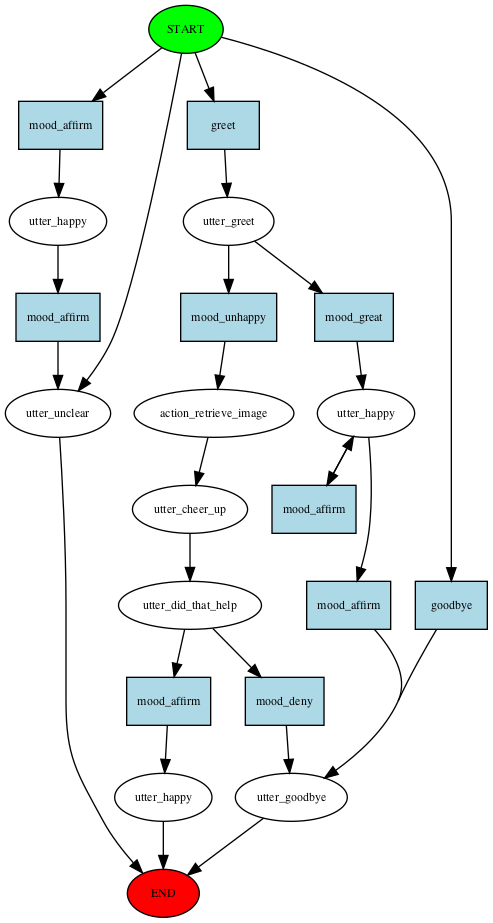

In [14]:
from IPython.display import Image
from rasa_core.agent import Agent

agent = Agent('domain.yml')
agent.visualize("stories.md", "story_graph.png", max_history=2)
Image(filename="story_graph.png")

### Training your Dialogue Model

Now comes the fun part! We're going to show Rasa Core the stories we wrote above, and train a model on these examples. 
In this case, the model is a neural network implemented in Keras which learns to predict which action to take next. 

In [20]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

# this will catch predictions the model isn't very certain about
# there is a threshold for the NLU predictions as well as the action predictions
fallback = FallbackPolicy(fallback_action_name="utter_unclear",
                          core_threshold=0.2,
                          nlu_threshold=0.6)

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy(), fallback])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')


agent.train(
    training_data,
    validation_split=0.0,
    epochs=400
)

agent.persist('models/dialogue')

Processed Story Blocks: 100%|██████████| 6/6 [00:00<00:00, 201.36it/s, # trackers=20]
Processed actions: 170it [00:00, 10713.42it/s, # examples=170]
INFO:rasa_core.policies.memoization:Memorized 170 unique action examples.
INFO:rasa_core.policies.keras_policy:Fitting model with 170 total samples and a validation split of 0.0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 5, 15)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                6144      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 297       
_________________________________________________________________
activation_2 (Activation)    (None, 9)                 0         
Total params: 6,441
Trainable params: 6,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
170/170 [==============================] - 1s 4ms/step - loss: 2.1963 - acc: 0.1059
Epoch 2/400
170/170 [==============================] - 0s 203us/step - loss: 2.1282 - acc: 0.2529
Epoch 3/400
170/170 [==============================] - 0s 194us/step - loss: 2

170/170 [==============================] - 0s 195us/step - loss: 0.4454 - acc: 0.9118
Epoch 76/400
170/170 [==============================] - 0s 196us/step - loss: 0.4669 - acc: 0.8765
Epoch 77/400
170/170 [==============================] - 0s 185us/step - loss: 0.4523 - acc: 0.9000
Epoch 78/400
170/170 [==============================] - 0s 172us/step - loss: 0.3857 - acc: 0.9176
Epoch 79/400
170/170 [==============================] - 0s 175us/step - loss: 0.4002 - acc: 0.9176
Epoch 80/400
170/170 [==============================] - 0s 179us/step - loss: 0.4088 - acc: 0.9176
Epoch 81/400
170/170 [==============================] - 0s 176us/step - loss: 0.4222 - acc: 0.9235
Epoch 82/400
170/170 [==============================] - 0s 177us/step - loss: 0.3981 - acc: 0.9059
Epoch 83/400
170/170 [==============================] - 0s 177us/step - loss: 0.3498 - acc: 0.9529
Epoch 84/400
170/170 [==============================] - 0s 175us/step - loss: 0.4158 - acc: 0.9176
Epoch 85/400
170/170 [=

170/170 [==============================] - 0s 191us/step - loss: 0.1059 - acc: 0.9882
Epoch 158/400
170/170 [==============================] - 0s 196us/step - loss: 0.1255 - acc: 0.9824
Epoch 159/400
170/170 [==============================] - 0s 194us/step - loss: 0.1193 - acc: 0.9824
Epoch 160/400
170/170 [==============================] - 0s 196us/step - loss: 0.1109 - acc: 0.9824
Epoch 161/400
170/170 [==============================] - 0s 192us/step - loss: 0.1118 - acc: 0.9824
Epoch 162/400
170/170 [==============================] - 0s 189us/step - loss: 0.1314 - acc: 0.9824
Epoch 163/400
170/170 [==============================] - 0s 192us/step - loss: 0.1251 - acc: 0.9706
Epoch 164/400
170/170 [==============================] - 0s 190us/step - loss: 0.1162 - acc: 0.9706
Epoch 165/400
170/170 [==============================] - 0s 188us/step - loss: 0.1195 - acc: 0.9824
Epoch 166/400
170/170 [==============================] - 0s 189us/step - loss: 0.1026 - acc: 0.9824
Epoch 167/400


170/170 [==============================] - 0s 181us/step - loss: 0.0695 - acc: 0.9824
Epoch 240/400
170/170 [==============================] - 0s 170us/step - loss: 0.0394 - acc: 1.0000
Epoch 241/400
170/170 [==============================] - 0s 171us/step - loss: 0.0443 - acc: 1.0000
Epoch 242/400
170/170 [==============================] - 0s 173us/step - loss: 0.0570 - acc: 0.9941
Epoch 243/400
170/170 [==============================] - 0s 186us/step - loss: 0.0623 - acc: 0.9824
Epoch 244/400
170/170 [==============================] - 0s 187us/step - loss: 0.0488 - acc: 1.0000
Epoch 245/400
170/170 [==============================] - 0s 186us/step - loss: 0.0453 - acc: 0.9941
Epoch 246/400
170/170 [==============================] - 0s 186us/step - loss: 0.0460 - acc: 0.9882
Epoch 247/400
170/170 [==============================] - 0s 185us/step - loss: 0.0605 - acc: 0.9824
Epoch 248/400
170/170 [==============================] - 0s 183us/step - loss: 0.0519 - acc: 0.9941
Epoch 249/400


170/170 [==============================] - 0s 180us/step - loss: 0.0237 - acc: 0.9941
Epoch 322/400
170/170 [==============================] - 0s 180us/step - loss: 0.0356 - acc: 0.9941
Epoch 323/400
170/170 [==============================] - 0s 190us/step - loss: 0.0456 - acc: 0.9824
Epoch 324/400
170/170 [==============================] - 0s 185us/step - loss: 0.0349 - acc: 0.9941
Epoch 325/400
170/170 [==============================] - 0s 184us/step - loss: 0.0275 - acc: 0.9941
Epoch 326/400
170/170 [==============================] - 0s 180us/step - loss: 0.0333 - acc: 0.9941
Epoch 327/400
170/170 [==============================] - 0s 183us/step - loss: 0.0174 - acc: 1.0000
Epoch 328/400
170/170 [==============================] - 0s 187us/step - loss: 0.0328 - acc: 0.9882
Epoch 329/400
170/170 [==============================] - 0s 184us/step - loss: 0.0629 - acc: 0.9882
Epoch 330/400
170/170 [==============================] - 0s 184us/step - loss: 0.0329 - acc: 0.9941
Epoch 331/400


INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Model directory models/dialogue exists and contains old model files. All files will be overwritten.
INFO:rasa_core.agent:Persisted model to '/Users/liuxinxin/Documents/GitHub/rasa-chinese/models/dialogue'


### Starting up the bot (with NLU)

Now that we've trained the dialogue **and** language understanding models and saved them, we can start up an `Agent` which will handle conversations for us. 

In [22]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

INFO:rasa_nlu.components:Added 'SpacyNLP' to component cache. Key 'SpacyNLP-zh_core_web_sm'.


### Talking to the Bot (with NLU)

We can start talking to the bot in natural language.

In [ ]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])


Your bot is ready to talk! Type your messages here or send 'stop'
嘿
嘿，你感觉怎么样?
我觉得还不错
looking for a good img
你看了可能会感觉不错: https://picsum.photos/200/300/?random
不知道我帮上忙没有?
没有
再见


### Evaluation of the dialogue model
As with the NLU model, instead of just subjectively testing the model, we can also evaluate the model on a dataset. You'll be using the training data set again, but usually you'd use a test data set separate from the training data.

In [ ]:
from rasa_core.evaluate import run_story_evaluation

run_story_evaluation("stories.md", "models/dialogue", 
                     nlu_model_path=None, 
                     max_stories=None, 
                     out_file_plot="story_eval.pdf")

### Interactive learning
Unfortunately, this doesn't work in jupyter yet. Hence, we going to do this on the command line. [The repository](https://github.com/tmbo/rasa-demo-pydata18)  contains a makefile with the instructions to run the interactive learning. So go ahead and run `make interactive` on the commandline (make sure your shell is in the righht virtual env).

# Part 3: Next steps

Great job! You've built your first bot that uses Machine Learning to manage dialogues. As a next step, we'd suggest you start building your own bot. Here are a few useful links:



*   Install the Rasa Stack on your machine [here](https://core.rasa.ai/installation.html)
*   Checkout more of the Docs: [NLU](https://nlu.rasa.com) and [Core](https://core.rasa.com)
*   Connect to the community in our [Gitter Chat](https://gitter.im/RasaHQ/rasa_core)



---




*Any feedback for this tutorial?* Please shoot me a mail at tom@rasa.com